In [1]:
import odl
import scipy.signal
%matplotlib inline
import astra
import numpy as np
import scipy.sparse.linalg

In [2]:
class Radon(odl.Operator):
    """Operator calculating the convolution of a kernel with a function"""
    def __init__(self, A, domain, range):
        self.A = A
        super().__init__(domain, range, True)
    
    def _call(self,x):
        return np.reshape(self.A*x.data.ravel(), self.range.shape)
    
    @property
    def adjoint(self):
        return Radon(self.A.T, self.range, self.domain) 
    
class RadonTimeAdjoint(odl.Operator):
    def __init__(self, A, range):
        #self.domain = domain
        #self.range = range
        self.diagop = A
        super().__init__(self.diagop.domain, range, True)

    
    def _call(self,x):
        #This time input is in right format for diagonal operator but must be reshaped to correct output
        product_space_result = self.diagop(x)
        data_in_operator_range = self.range.element(np.transpose(np.array([part.data for part in product_space_result.parts]),(1,2,0)))
        return data_in_operator_range
        
    
class RadonTime(odl.Operator):
    def __init__(self, *A, domain):
        #self.domain = domain
        #self.range = range
        self.diagop = odl.DiagonalOperator(*A)
        super().__init__(domain, self.diagop.range, True)

    
    def _call(self,x):
        #x is an nd image with last dimension being time. Reshape into product space where dimension of time is the power
        data_in_diag_domain = self.diagop.domain.element(np.transpose(x.data, (2,0,1)))
        product_space_result = self.diagop(data_in_diag_domain)
        return product_space_result
        
    
    @property
    def adjoint(self):
        return RadonTimeAdjoint(self.diagop.adjoint, self.domain)
    

In [3]:
frames = 8 #this is number of frames we want to reconstruct, not meaning it's static for 300 theta in a row.
thetas = np.array_split(np.linspace(0,8*np.pi,2400,False),8)
As = []
for t in range(frames):
    vol_geom = astra.create_vol_geom(128, 128)
    proj_geom = astra.create_proj_geom('parallel', 1.0, 128, thetas[t])

    vol_geom = vol_geom
    proj_geom = proj_geom
    proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
    A = astra.OpTomo(proj_id)
    image_space = odl.uniform_discr([vol_geom["option"]["WindowMinX"],vol_geom["option"]["WindowMinY"]],[vol_geom["option"]["WindowMaxX"],vol_geom["option"]["WindowMaxY"]],[vol_geom["GridRowCount"], vol_geom["GridColCount"]])
    radon_space = odl.uniform_discr([proj_geom["ProjectionAngles"][0],0],[proj_geom["ProjectionAngles"][-1],proj_geom["DetectorCount"]*proj_geom["DetectorWidth"]],[len(proj_geom["ProjectionAngles"]), proj_geom["DetectorCount"]])
    if t !=  1:
        As.append(Radon(A,image_space,radon_space))
    

image_space = odl.uniform_discr([-50,-50,0], [50,50,7], (128,128,7))

TimeOp = RadonTime(*As, domain=image_space)
TimeOp.domain, TimeOp.range.shape


/home/mette/anaconda3/envs/odl-py37/lib/python3.7/site-packages/scipy/sparse/sputils.py:114: UserWarning: object dtype is not supported by sparse matrices
  warnings.warn("object dtype is not supported by sparse matrices")


(uniform_discr([-50., -50.,   0.], [ 50.,  50.,   7.], (128, 128, 7)), (7,))

In [16]:
#Now lets load data with actual movements
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
from ImageSliceViewer3D import *
import matplotlib
from tqdm import tqdm
matplotlib.rcParams['figure.figsize'] = (10, 10)

filepath = "PhantomGenerator/output/RECTVData"
files = [file for file in np.sort(listdir(filepath)) if file.endswith(".npy")]
height, width = np.load(join(filepath,files[0])).shape
depth = len(files)
volume = np.zeros((depth, height, width))
for i,file in tqdm(enumerate(files)):
    volume[i,:,:] = np.load(join(filepath,file))

volume = volume[:,:,:].astype('float32')

2400it [00:16, 148.99it/s]


In [5]:
volume.shape

(2400, 128, 128)

In [6]:
temp = np.split(volume[:,58,:], 8)
del temp[1]
len(temp)
sinogram_spaces = TimeOp.range.element(temp)

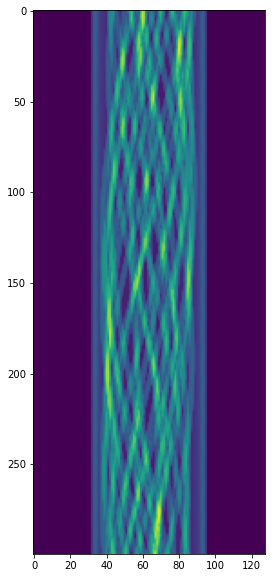

In [7]:
plt.imshow(sinogram_spaces[1])

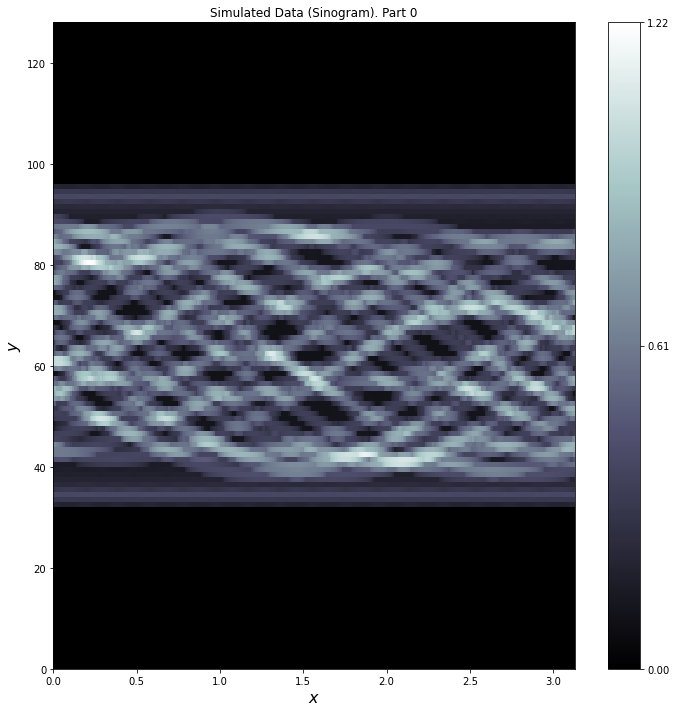

<Figure size 720x720 with 0 Axes>

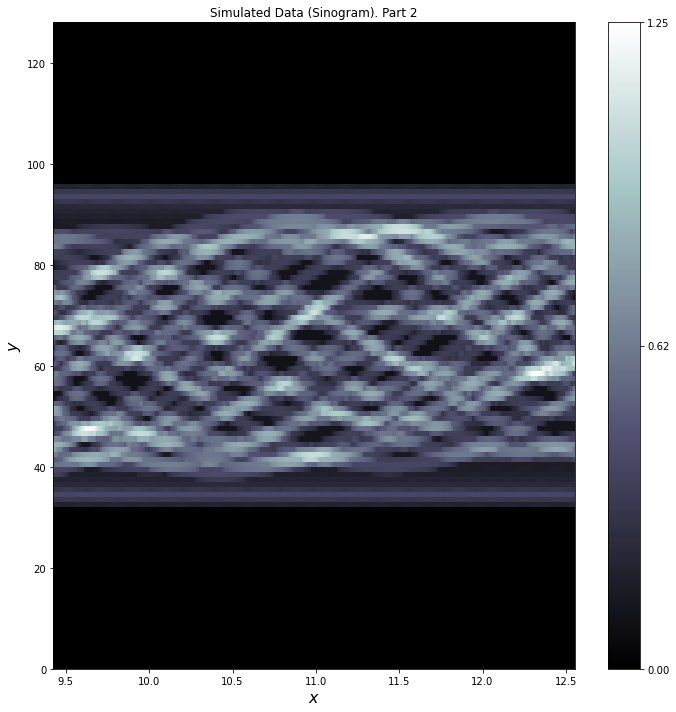

<Figure size 720x720 with 0 Axes>

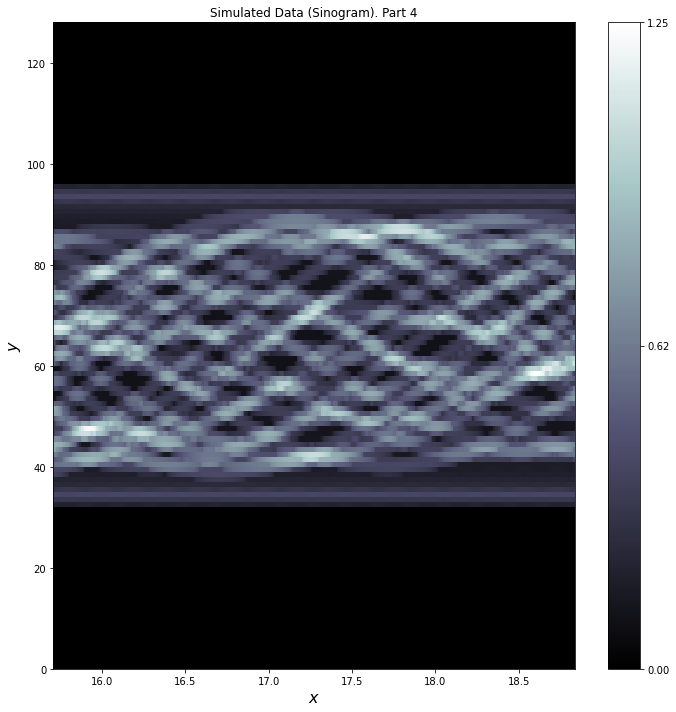

<Figure size 720x720 with 0 Axes>

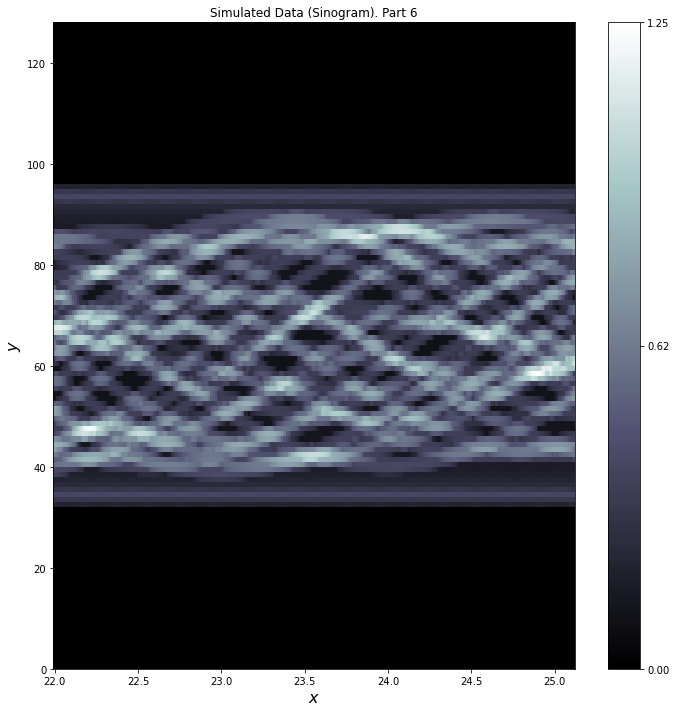

<Figure size 720x720 with 0 Axes>

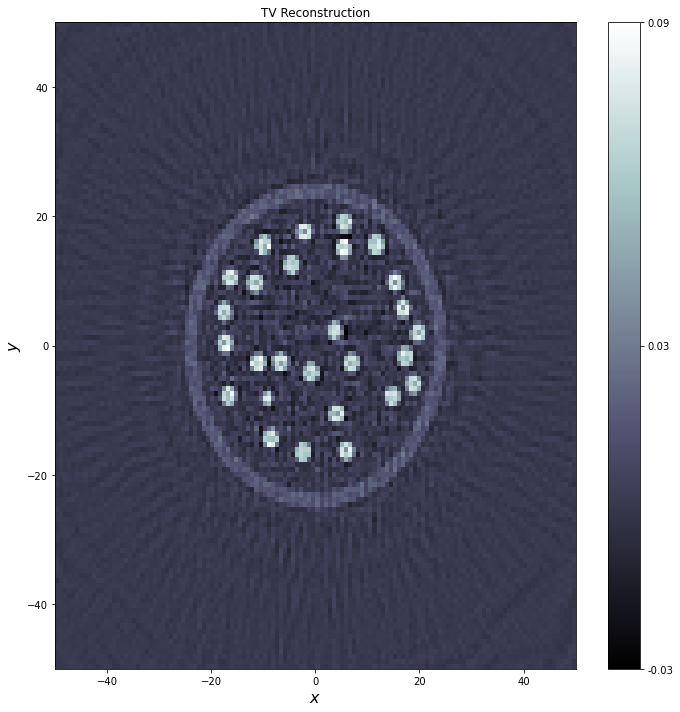

<Figure size 720x720 with 0 Axes>

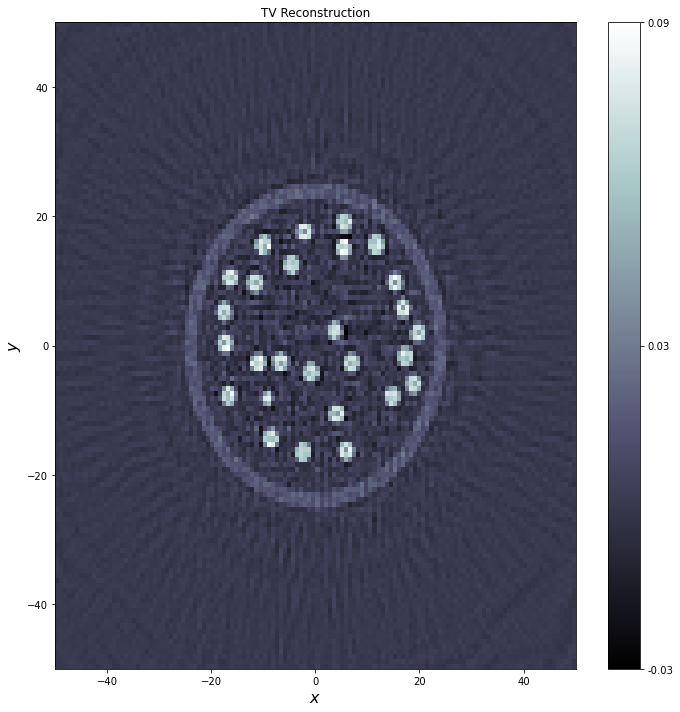

In [8]:
lamda_1 = 0.1
lamda_2 = 0.0

gradient = odl.Gradient(domain=TimeOp.domain)
A = TimeOp
#Then lamda weighting
weights = np.ones(gradient.range.shape)
weights[2,:,:,:] = weights[2,:,:]*lamda_2
weight_vec = gradient.range.element(weights)
weighted_gradient = odl.OperatorLeftVectorMult(gradient, weight_vec)


L = odl.BroadcastOperator(A,weighted_gradient)
f = odl.solvers.ZeroFunctional(L.domain)
norm_2 = odl.solvers.L2NormSquared(A.range).translated(sinogram_spaces)

norm_1 = lamda_1*odl.solvers.L1Norm(weighted_gradient.range)
g = odl.solvers.SeparableSum(norm_2,norm_1)
op_norm = odl.power_method_opnorm(L)

#not necessarily optimal choice but gaurantess convergence!
sigma = 1/(1.1*op_norm)
tau = 1/(1.1*op_norm)

x = L.domain.zero()
# Optionally pass callback to the solver to display intermediate results
#callback = (odl.solvers.CallbackPrintIteration(step=10) &
#            odl.solvers.CallbackShow(step=10))

# Run the algorithm
odl.solvers.pdhg(x, f, g, L, niter=200, tau=tau, sigma=sigma)
  #               callback=callback)

# Display images
#volume.show(title='Phantom')
sinogram_spaces.show(title='Simulated Data (Sinogram)')
x.show(title='TV Reconstruction', force_show=True)

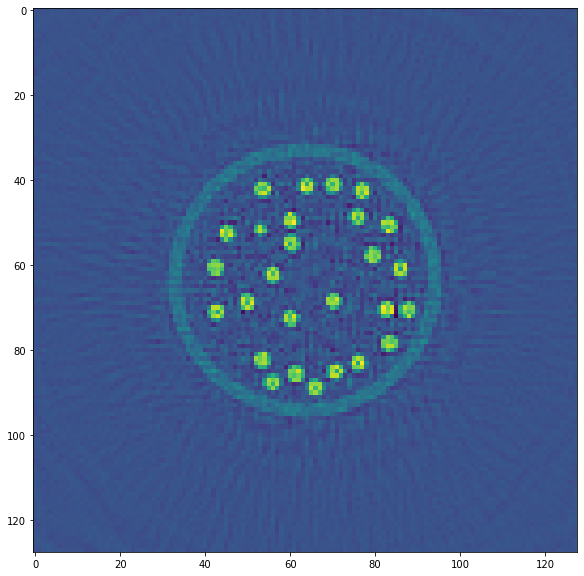

In [9]:
plt.imshow(x[:,:,0])

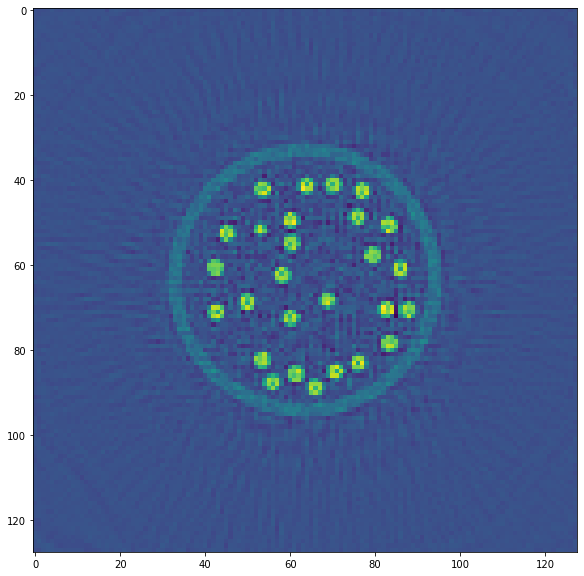

In [10]:
plt.imshow(x[:,:,1])

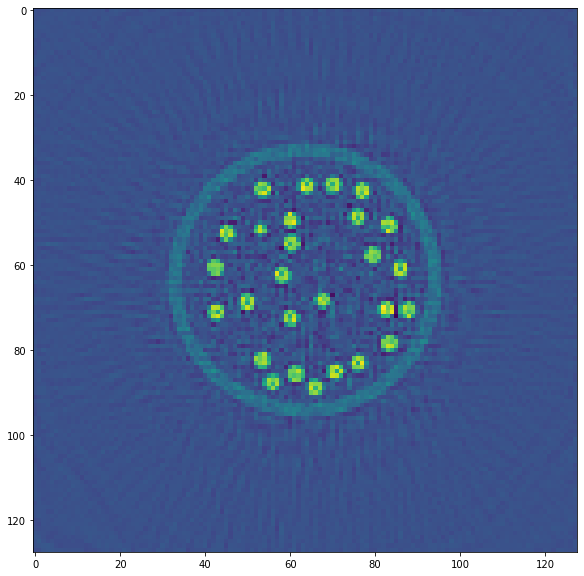

In [11]:
plt.imshow(x[:,:,2])

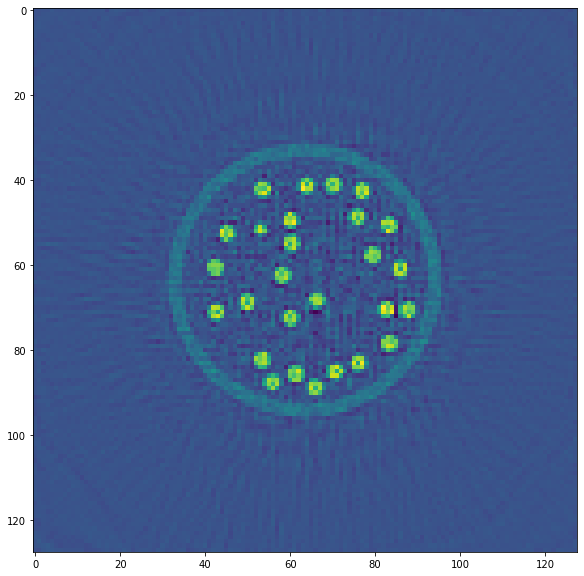

In [12]:
plt.imshow(x[:,:,3])

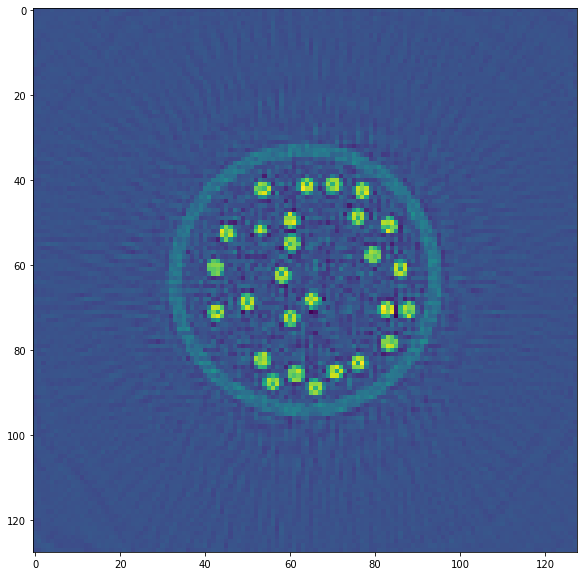

In [13]:
plt.imshow(x[:,:,4])

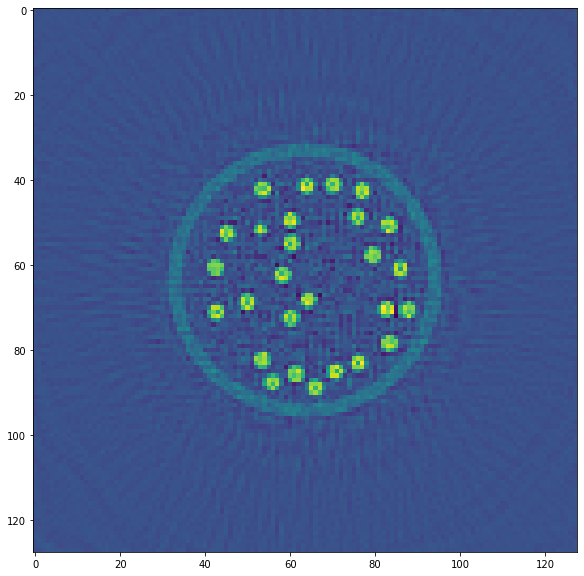

In [14]:
plt.imshow(x[:,:,5])

In [17]:
plt.imshow(x[:,:,19])

IndexError: index 19 is out of bounds for axis 2 with size 7